In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [15]:
# Load dataset
train_data = pd.read_csv('cs-training.csv')
test_data = pd.read_csv('cs-test.csv')
data_dict = pd.read_excel('Data Dictionary.xls')
sample_entry = pd.read_csv('SampleEntry.csv')

In [16]:
# Display sample contents of files
print("Train Data Sample:")
print(train_data.head())
print("\nTest Data Sample:")
print(test_data.head())
print("\nData Dictionary Sample:")
print(data_dict.head())
print("\nSample Entry File:")
print(sample_entry.head())

Train Data Sample:
   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13

In [17]:
# Drop ID column
train_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
test_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [18]:
# Check missing values
train_data.fillna(train_data.median(), inplace=True)
test_data.fillna(test_data.median(), inplace=True)

In [19]:
# Define features and target
X = train_data.drop(columns=['SeriousDlqin2yrs'])
y = train_data['SeriousDlqin2yrs']

In [20]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [21]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_data.drop(columns=['SeriousDlqin2yrs'], errors='ignore'))

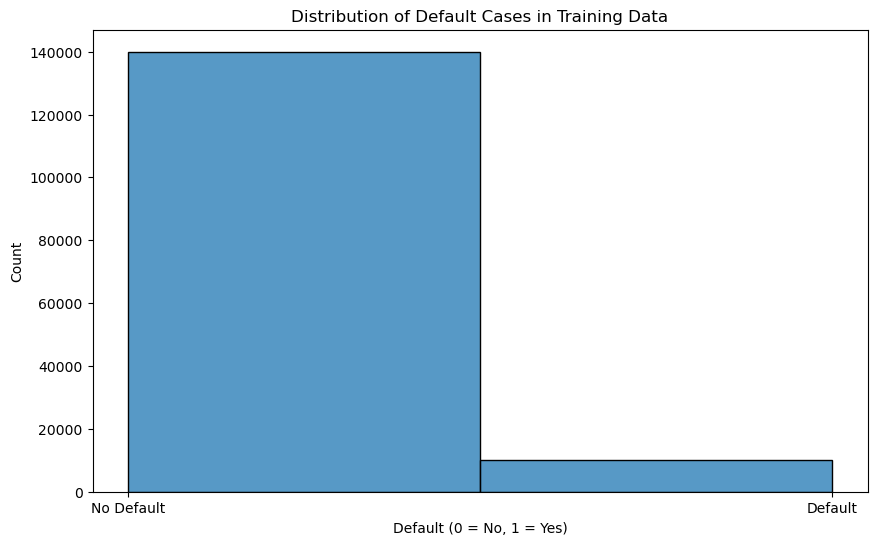

In [23]:
# Visualizing Data Distributions
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SeriousDlqin2yrs'], bins=2, kde=False)
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Distribution of Default Cases in Training Data')
plt.xticks([0, 1], ['No Default', 'Default'])
plt.show()

In [ ]:
# Train models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

if xgboost_available:
    models['XGBoost'] = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    results[name] = auc_score
    print(f'\n{name} Model Performance:')
    print(classification_report(y_val, y_pred))
    print(f'ROC-AUC Score: {auc_score}')
   

In [ ]:
 
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [ ]:
# Best Model Selection
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f'Best Model: {best_model_name} with AUC: {results[best_model_name]}')

In [ ]:
# Generate Predictions for Test Data
test_predictions = best_model.predict_proba(X_test)[:, 1]
sample_entry['Probability'] = test_predictions

In [ ]:
# Save final predictions
sample_entry.to_csv('FinalPredictions.csv', index=False)
print("Predictions saved to FinalPredictions.csv")

In [ ]:
# Risk Analysis
train_data['Predicted_Risk'] = best_model.predict(X)
plt.figure(figsize=(8, 5))
sns.histplot(train_data['Predicted_Risk'], bins=2, kde=False)
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.title('Distribution of Predicted Credit Risk')
plt.xticks([0, 1], ['Low Risk', 'High Risk'])
plt.show()

In [ ]:
# Visualizing feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()